In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import time
pd.set_option('mode.chained_assignment', None)

In [2]:
# Function to create lagged features
def create_lagged_features(data, lag=1):
    for i in range(1, lag+1):
        data[f'humi_lag_{i}'] = data['humi'].shift(i)
    return data

# function for converting '-' values to numbers
# col_k : 'k_temp' or col_k : 'k_rain'
def col_k_dash_remover(df, col_k):
    if len(df) != 0:
        cnt = 0
        for i in range(len(df)):
            # Num_rows : 1
            if len(df) == 1 and '-' in df[col_k].iloc[i]:
                df[col_k].iloc[i] = 0
            # Num_rows : 2
            if len(df) == 2 and i == 0:
                if '-' in df[col_k].iloc[i] and '-' not in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = df[col_k].iloc[i+1]
                elif '-' not in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:    
                    df[col_k].iloc[i+1] = df[col_k].iloc[i]
                elif '-' in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = 0
                    df[col_k].iloc[i+1] = 0
            # ----------------------------------------------------------------------------------
            # Num_rows > 2
            if len(df) > 2:
                ## initial term
                if i == 0 and '-' in df[col_k].iloc[i]: 
                    # CASE1 : '-' // num
                    if '-' not in df[col_k].iloc[i+1]:
                        #print('CASE1-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i+1]
                    # CASE2 : '-' // '-'
                    elif '-' in df[col_k].iloc[i+1]:
                        #df[col_k].iloc[i] = 0
                        #print('CASE1-2')
                        cnt += 1
                        continue
                ## middle term ---------------------------------------------------------------------------
                elif i > 0 and '-' in df[col_k].iloc[i]:
                     # CASE1 : ordinary ; prev : num // current : '-' // next : num 
                    if '-' not in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        #print('CASE2-1')
                        df[col_k].iloc[i] = str((int(df[col_k].iloc[i-1]) + int(df[col_k].iloc[i+1]))//2)
                    # CASE2 : '-' // '-' // '-'
                    elif '-' in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #print('CASE2-2')
                        cnt += 1
                        continue
                    # CASE3 : num // '-' // '-'
                    elif '-' not in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #print('CASE2-3')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE4 : '-' // '-' // num
                    elif '-' in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        cnt += 1
                        # sum
                        #print('CASE2-4')
                        for j in range(cnt):
                            #print('i : {}'.format(i))
                            #print('j : {}'.format(j))
                            #print('cnt : {}'.format(cnt))
                            #print('i - cnt + j : {}'.format(i-cnt+j+1))
                            df[col_k].iloc[i-cnt+j+1] = df[col_k].iloc[i+1]
                            #print(df[col_k].iloc[i+1])
                            #print('-'*10)
                            #print(df[col_k].iloc[i-cnt+j+1])
                            #print('-'*20)
                        # -------
                        cnt = 0
                # -------------------------------------------------------------------------------------------
                ## final term
                elif i == len(df) - 1 and '-' in df[col_k].iloc[i]:
                    # CASE1 : num // '-'
                    if '-' not in df[col_k].iloc[i-1]:
                        #print('CASE3-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE2 : '-' // '-' # ex. in the case all data values : '-'
                    elif '-' in df[col_k].iloc[i-1]:
                        #print('CASE3-2')
                        # sum
                        if cnt == len(df) - 1:
                            for j in range(cnt):
                                df[col_k].iloc[j] = 0
                        else:
                            print('CASE3-4')
                            print('case inspection needed ...')
# =============================================================================================================
def ts_df_maker(df,year,month,period):
    if period > 1: # add extra conditions later
        for i in range(period):
            if len(str(month)) == 1:
                ym = str(year) + '-0' + str(month)
                print('Period > 1')
                print(ym)
            elif len(str(month)) == 2:
                ym = str(year) + '-' + str(month)
                print('Period > 1')
                print(ym)
            # ------------------------------------------------
            if i == 0:
                df_ = df[df['sensingTime'].str.contains(ym)]
            else:
                df0 = df_
                df_ = pd.concat([df0, df[df['sensingTime'].str.contains(ym)]], axis = 0)
            month += 1
    elif period == 1:
        if len(str(month)) == 1:
            ym = str(year) + '-0' + str(month)
            print('Period : 1')
            print(ym)
        elif len(str(month)) == 2:
            ym = str(year) + '-' + str(month)
        df_ = df[df['sensingTime'].str.contains(ym)]
    else:
        print('Reset the period.')
        df_ = df    
            
    return df_

In [3]:
def build_model(X_train):
    from tensorflow.keras.models import Sequential
    
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))  # Output layer with 1 neuron for predicting humidity

    # Compile the model
    model.compile(optimizer='adam', loss='mse')  # Mean Squared Error is used as the loss function
    
    return model

def fit_model(model,X_train,y_train):
    # Train the model
    #model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
def scale_data(df_input):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    df_input_scaled = scaler.fit_transform(df_input)
    df_input_scaled_ = df_input_scaled.reshape((df_input_scaled.shape[0],1,df_input_scaled.shape[1]))
    # -----------------------------------------------------------------------------------------------
    
    return df_input_scaled_

def scale_data_target(df_input):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()
    df_input_scaled = scaler.fit_transform(df_input)
    df_input_scaled_ = df_input_scaled.reshape((df_input_scaled.shape[0],1,df_input_scaled.shape[1]))
    # -----------------------------------------------------------------------------------------------
    
    return df_input_scaled_,scaler


def predict_data(model, X_sep):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    #scaler = MinMaxScaler()
    # Predict on the reshaped data
    y_sep_predicted = model.predict(X_sep)
    # ------------------------------------------------------------------------------------
    # Reshape the predicted values to (n_samples, 1)
    y_sep_predicted_reshaped = y_sep_predicted.reshape((y_sep_predicted.shape[0], 1))
    # Inverse transform the reshaped predicted values to the original scale
    y_sep_pred = scaler.inverse_transform(
        np.hstack([y_sep_predicted_reshaped, np.zeros((y_sep_predicted_reshaped.shape[0], X_sep.shape[1] - 1))])
    )
    return y_sep_pred


def predict_data_target(model, X_sep, scaler):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    #scaler = MinMaxScaler()
    # Predict on the reshaped data
    y_sep_predicted = model.predict(X_sep)
    # ------------------------------------------------------------------------------------
    # Reshape the predicted values to (n_samples, 1)
    y_sep_predicted_reshaped = y_sep_predicted.reshape((y_sep_predicted.shape[0], 1))
    # Inverse transform the reshaped predicted values to the original scale
    y_sep_pred = scaler.inverse_transform(
        np.hstack([y_sep_predicted_reshaped, np.zeros((y_sep_predicted_reshaped.shape[0], X_sep.shape[2] - 1))])
    )
    return y_sep_pred

def model_eval(model,X_test,y_test):
    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Mean Squared Error on Test Data: {loss}')
    
def save_ypred_df(y_sep_pred):
    # Extract the first column to get the desired shape (193, 1)
    y_sep_pred_column = y_sep_pred[:, 0].reshape(-1, 1)
    y_sep_pred_df = pd.DataFrame(y_sep_pred_column)
    return y_sep_pred_df

def process_model(X_build,X_fit,y_fit,X_target,scaler):
    # build model
    model = build_model(X_build)
    # fit model
    fit_model(model,X_fit,y_fit)
    ##model_eval(model,X_target,y_target) # optional
    #y_pred = predict_data(model, X_target, scaler)
    y_pred = predict_data_target(model, X_target, scaler)
    df_y_pred = save_ypred_df(y_pred)
    return df_y_pred



#### Sensor 32

In [4]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000032'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 2
# -------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
# -----------------------------------

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11


In [5]:
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)

In [6]:
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)



Epoch 1/50

7/7 [==============================] - 1s 1ms/step - loss: 0.1630
Epoch 2/50
7/7 [==============================] - 0s 996us/step - loss: 0.0948
Epoch 3/50
7/7 [==============================] - 0s 950us/step - loss: 0.0527
Epoch 4/50
7/7 [==============================] - 0s 836us/step - loss: 0.0317
Epoch 5/50
7/7 [==============================] - 0s 856us/step - loss: 0.0256
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0256
Epoch 7/50
7/7 [==============================] - 0s 977us/step - loss: 0.0252
Epoch 8/50
7/7 [==============================] - 0s 752us/step - loss: 0.0235
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 12/50
7/7 [==============================] - 0s 836us/step - loss: 0.0193
Epoch 13/50
7/7 [==============================] - 0s 1m

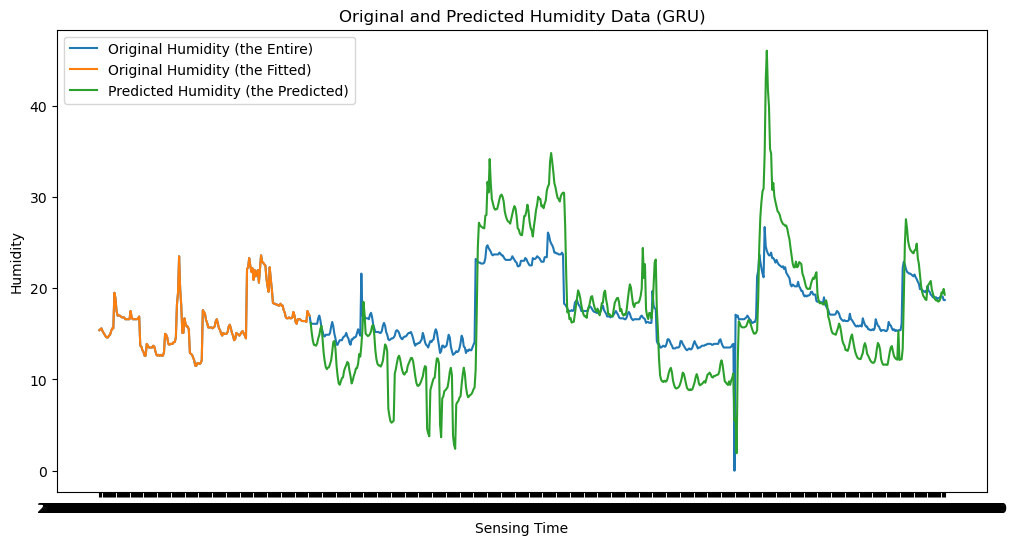

In [7]:
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title('Original and Predicted Humidity Data (GRU)')
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

In [18]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000016'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 2
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 11
period_target = 1

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period > 1
2023-09
Period > 1
2023-10
Epoch 1/50
18/18 [==============================] - 1s 824us/step - loss: 0.1221
Epoch 2/50
18/18 [==============================] - 0s 833us/step - loss: 0.0337
Epoch 3/50
18/18 [==============================] - 0s 795us/step - loss: 0.0179
Epoch 4/50
18/18 [==============================] - 0s 825us/step - loss: 0.0091
Epoch 5/50
18/18 [==============================] - 0s 854us/step - loss: 0.0058
Epoch 6/50
18/18 [==============================] - 0s 824us/step - loss: 0.0047
Epoch 7/50
18/18 [==============================] - 0s 824us/step - loss: 0.0041
Epoch 8/50
18/18 [==============================] - 0s 825us/step - loss: 0.0037
Epoch 9/50
18/18 [==============================] - 0s 773us/step - loss: 0.0034
Epoch 10/50
18/18 [==============================] - 0s 853us/step - loss: 0.0032
Epoch 11/50
18/18 [====================

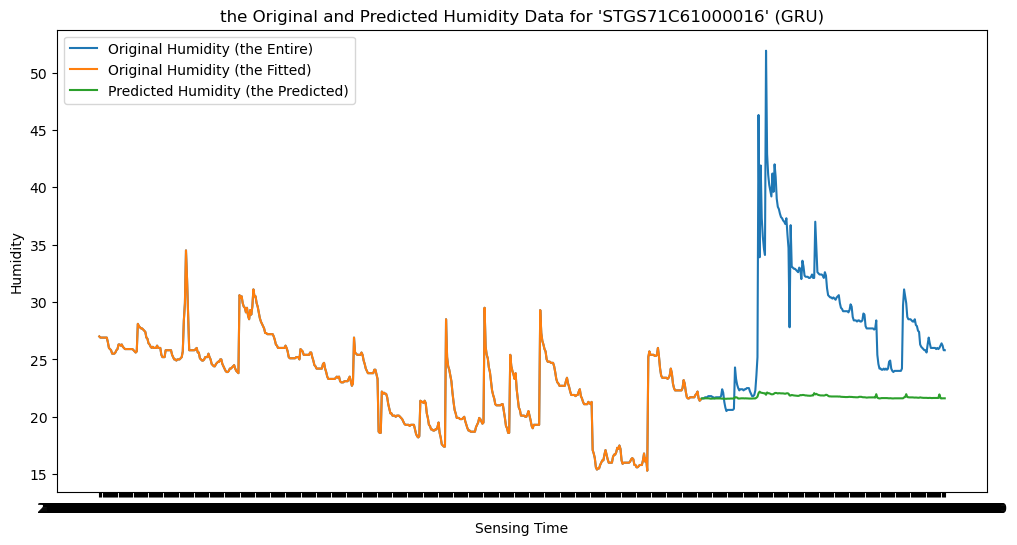

In [19]:
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

In [20]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000028'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 2
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 11
period_target = 1

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period > 1
2023-09
Period > 1
2023-10
Epoch 1/50
18/18 [==============================] - 1s 854us/step - loss: 0.1477
Epoch 2/50
18/18 [==============================] - 0s 824us/step - loss: 0.0170
Epoch 3/50
18/18 [==============================] - 0s 854us/step - loss: 0.0110
Epoch 4/50
18/18 [==============================] - 0s 824us/step - loss: 0.0069
Epoch 5/50
18/18 [==============================] - 0s 795us/step - loss: 0.0047
Epoch 6/50
18/18 [==============================] - 0s 887us/step - loss: 0.0037
Epoch 7/50
18/18 [==============================] - 0s 853us/step - loss: 0.0032
Epoch 8/50
18/18 [==============================] - 0s 825us/step - loss: 0.0027
Epoch 9/50
18/18 [==============================] - 0s 825us/step - loss: 0.0025
Epoch 10/50
18/18 [==============================] - 0s 794us/step - loss: 0.0022
Epoch 11/50
18/18 [====================

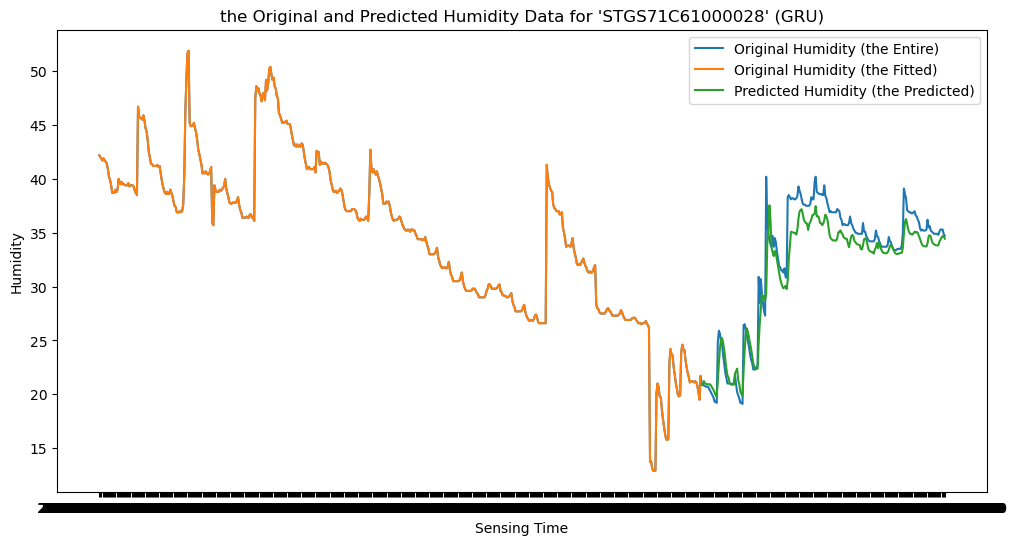

In [21]:
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period > 1
2023-09
Period > 1
2023-10
Epoch 1/50
18/18 [==============================] - 1s 883us/step - loss: 0.0695
Epoch 2/50
18/18 [==============================] - 0s 853us/step - loss: 0.0146
Epoch 3/50
18/18 [==============================] - 0s 862us/step - loss: 0.0084
Epoch 4/50
18/18 [==============================] - 0s 854us/step - loss: 0.0055
Epoch 5/50
18/18 [==============================] - 0s 854us/step - loss: 0.0043
Epoch 6/50
18/18 [==============================] - 0s 854us/step - loss: 0.0040
Epoch 7/50
18/18 [==============================] - 0s 854us/step - loss: 0.0038
Epoch 8/50
18/18 [==============================] - 0s 795us/step - loss: 0.0038
Epoch 9/50
18/18 [==============================] - 0s 824us/step - loss: 0.0036
Epoch 10/50
18/18 [==============================] - 0s 825us/step - loss: 0.0035
Epoch 11/50
18/18 [====================

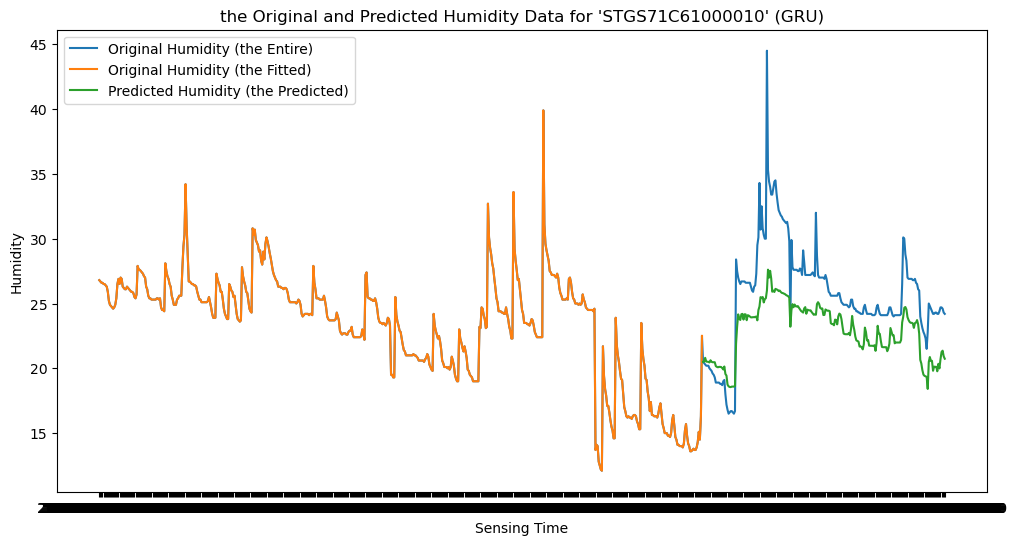

In [56]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000010'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 2
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 11
period_target = 1
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period > 1
2023-09
Period > 1
2023-10
Epoch 1/50
18/18 [==============================] - 1s 883us/step - loss: 0.0511
Epoch 2/50
18/18 [==============================] - 0s 853us/step - loss: 0.0152
Epoch 3/50
18/18 [==============================] - 0s 832us/step - loss: 0.0040
Epoch 4/50
18/18 [==============================] - 0s 824us/step - loss: 0.0023
Epoch 5/50
18/18 [==============================] - 0s 795us/step - loss: 0.0020
Epoch 6/50
18/18 [==============================] - 0s 825us/step - loss: 0.0017
Epoch 7/50
18/18 [==============================] - 0s 917us/step - loss: 0.0016
Epoch 8/50
18/18 [==============================] - 0s 854us/step - loss: 0.0015
Epoch 9/50
18/18 [==============================] - 0s 825us/step - loss: 0.0014
Epoch 10/50
18/18 [==============================] - 0s 825us/step - loss: 0.0013
Epoch 11/50
18/18 [====================

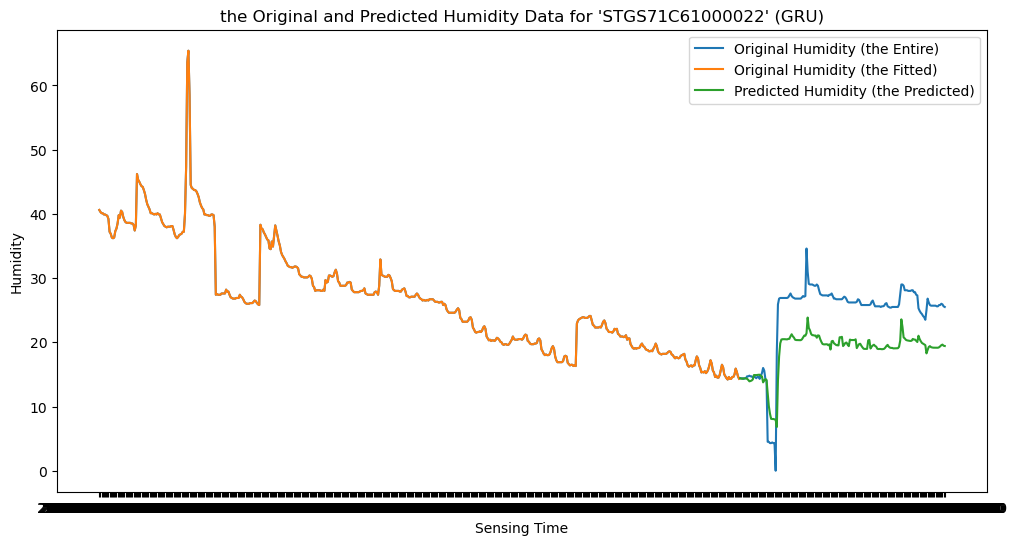

In [57]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000022'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 2
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 11
period_target = 1
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.1449
Epoch 2/50
7/7 [==============================] - 0s 919us/step - loss: 0.0899
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0597
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0488
Epoch 5/50
7/7 [==============================] - 0s 918us/step - loss: 0.0466
Epoch 6/50
7/7 [==============================] - 0s 919us/step - loss: 0.0434
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0384
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0346
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0313
Epoch 10/50
7/7 [==============================] - 0s 918us/step - loss: 0.0283
Epoch 11/50
7/7 [==============================] - 0

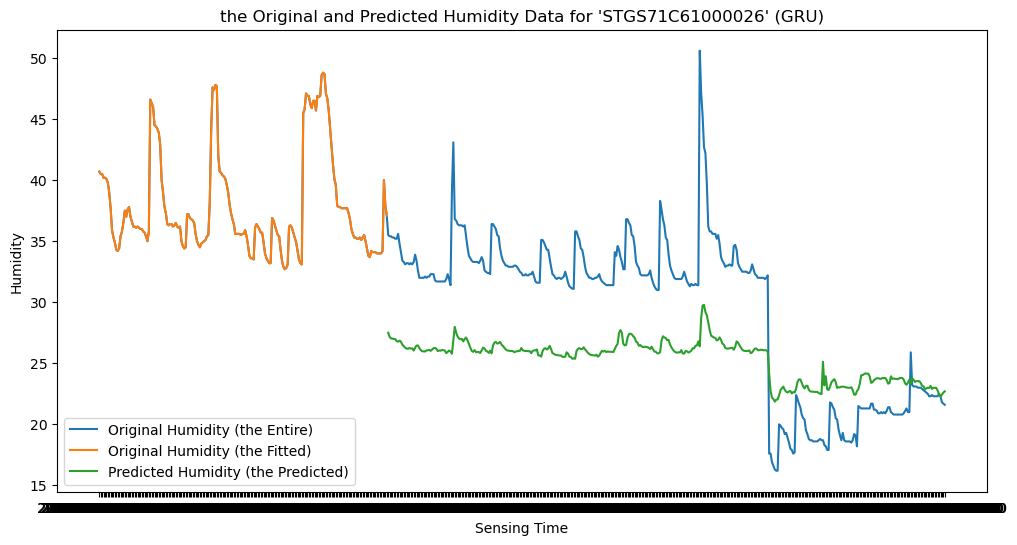

In [61]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000026'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
6/6 [==============================] - 1s 1ms/step - loss: 0.2584
Epoch 2/50
6/6 [==============================] - 0s 1ms/step - loss: 0.1737
Epoch 3/50
6/6 [==============================] - 0s 902us/step - loss: 0.1142
Epoch 4/50
6/6 [==============================] - 0s 800us/step - loss: 0.0727
Epoch 5/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0555
Epoch 6/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 7/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0468
Epoch 8/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 9/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0345
Epoch 10/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0302
Epoch 11/50
6/6 [==============================] - 0s 1m

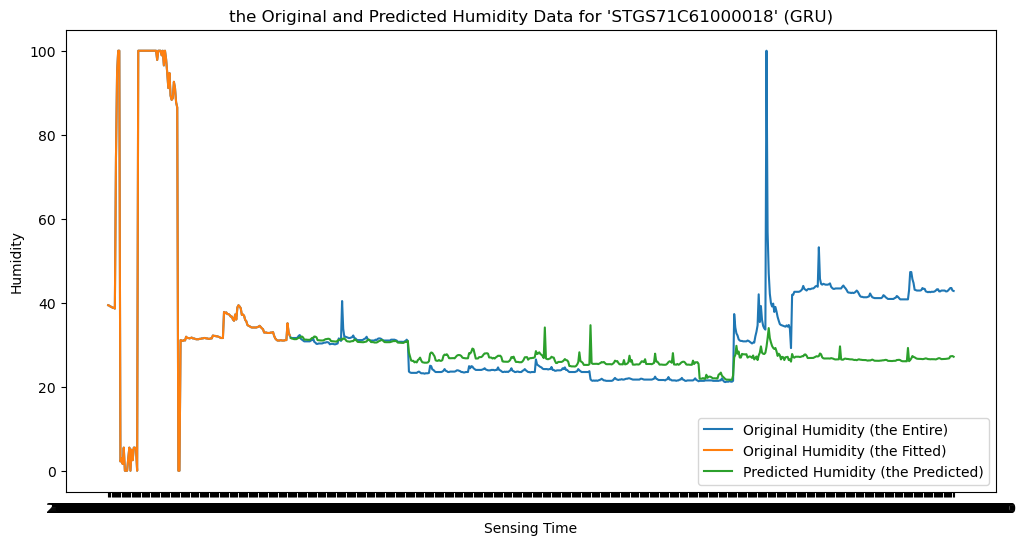

In [62]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000018'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0324
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0184
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 4/50
7/7 [==============================] - 0s 845us/step - loss: 0.0144
Epoch 5/50
7/7 [==============================] - 0s 966us/step - loss: 0.0129
Epoch 6/50
7/7 [==============================] - 0s 948us/step - loss: 0.0114
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 9/50
7/7 [==============================] - 0s 919us/step - loss: 0.0088
Epoch 10/50
7/7 [==============================] - 0s 917us/step - loss: 0.0083
Epoch 11/50
7/7 [==============================] -

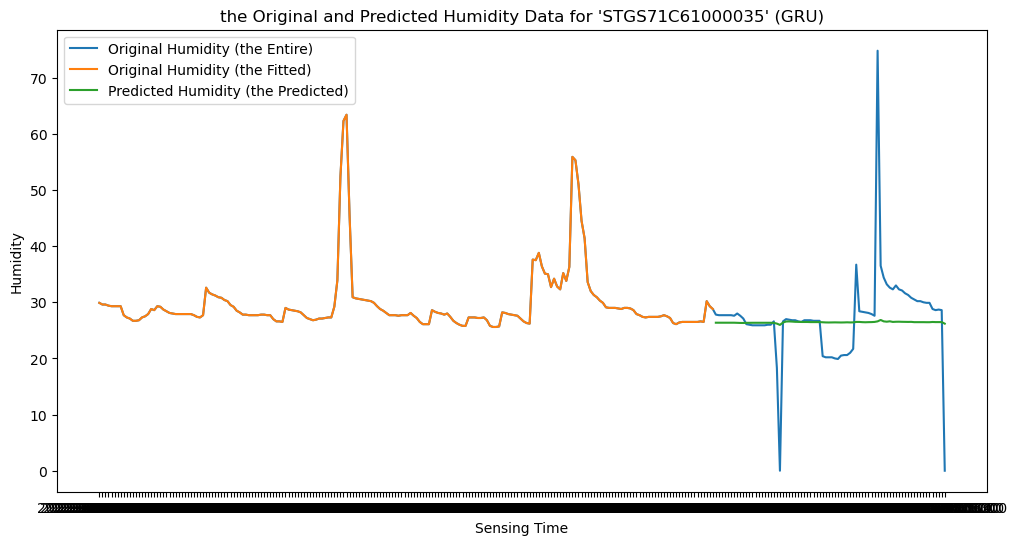

In [63]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000035'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

In [ ]:
'''pass 36 '''

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0337
Epoch 2/50
7/7 [==============================] - 0s 917us/step - loss: 0.0289
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 4/50
7/7 [==============================] - 0s 918us/step - loss: 0.0216
Epoch 5/50
7/7 [==============================] - 0s 919us/step - loss: 0.0191
Epoch 6/50
7/7 [==============================] - 0s 833us/step - loss: 0.0168
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0149
Epoch 8/50
7/7 [==============================] - 0s 919us/step - loss: 0.0135
Epoch 9/50
7/7 [==============================] - 0s 917us/step - loss: 0.0121
Epoch 10/50
7/7 [==============================] - 0s 834us/step - loss: 0.0114
Epoch 11/50
7/7 [===========================

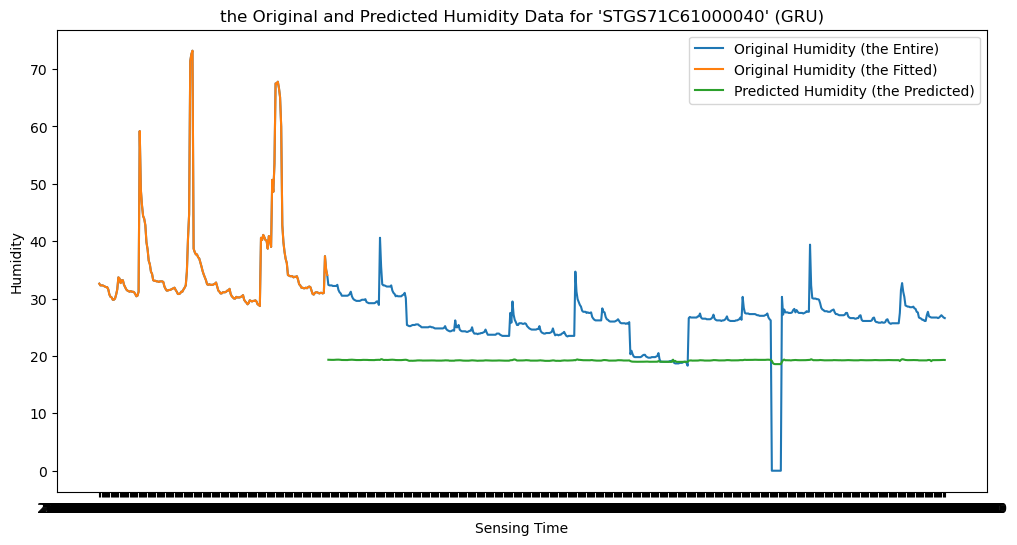

In [65]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000040'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
6/6 [==============================] - 1s 1ms/step - loss: 0.1405
Epoch 2/50
6/6 [==============================] - 0s 836us/step - loss: 0.0901
Epoch 3/50
6/6 [==============================] - 0s 800us/step - loss: 0.0561
Epoch 4/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 5/50
6/6 [==============================] - 0s 787us/step - loss: 0.0372
Epoch 6/50
6/6 [==============================] - 0s 818us/step - loss: 0.0357
Epoch 7/50
6/6 [==============================] - 0s 958us/step - loss: 0.0310
Epoch 8/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 9/50
6/6 [==============================] - 0s 963us/step - loss: 0.0233
Epoch 10/50
6/6 [==============================] - 0s 906us/step - loss: 0.0206
Epoch 11/50
6/6 [=============================

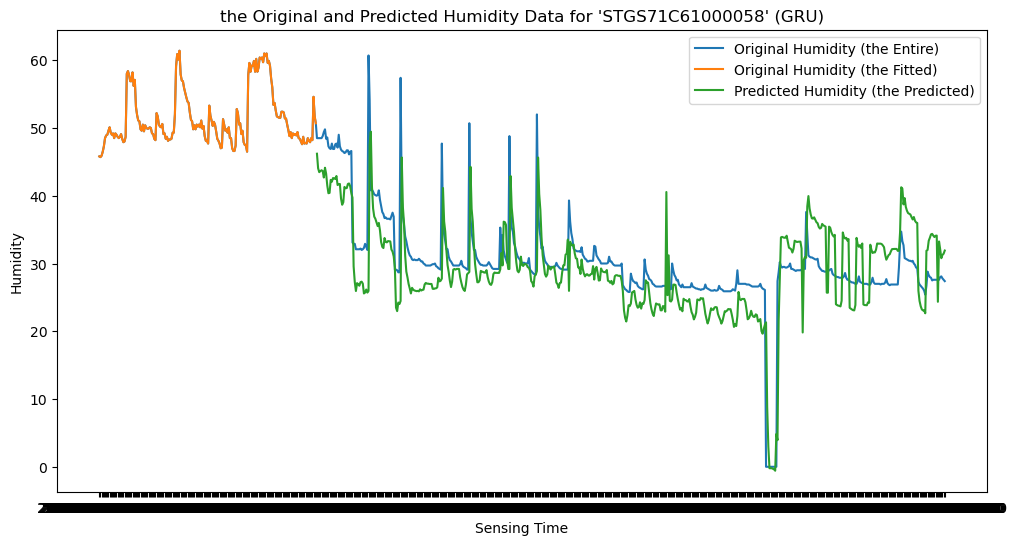

In [66]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000058'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.2534
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1534
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0797
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0377
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0275
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 7/50
7/7 [==============================] - 0s 918us/step - loss: 0.0263
Epoch 8/50
7/7 [==============================] - 0s 918us/step - loss: 0.0224
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0205
Epoch 10/50
7/7 [==============================] - 0s 918us/step - loss: 0.0187
Epoch 11/50
7/7 [==============================] - 0

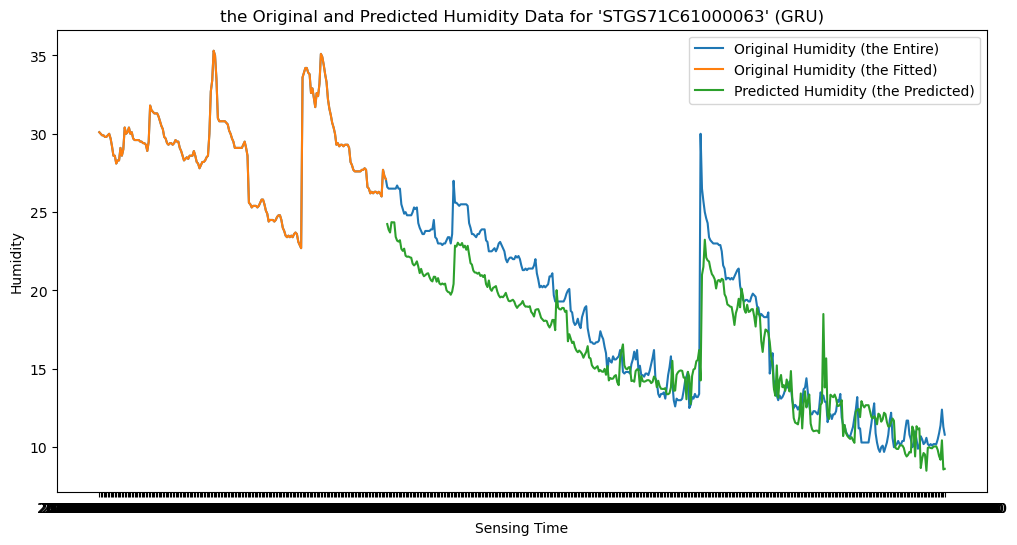

In [67]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000063'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.2623
Epoch 2/50
7/7 [==============================] - 0s 833us/step - loss: 0.1293
Epoch 3/50
7/7 [==============================] - 0s 834us/step - loss: 0.0591
Epoch 4/50
7/7 [==============================] - 0s 918us/step - loss: 0.0404
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0368
Epoch 6/50
7/7 [==============================] - 0s 834us/step - loss: 0.0287
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0215
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0181
Epoch 9/50
7/7 [==============================] - 0s 917us/step - loss: 0.0158
Epoch 10/50
7/7 [==============================] - 0s 833us/step - loss: 0.0138
Epoch 11/50
7/7 [=============================

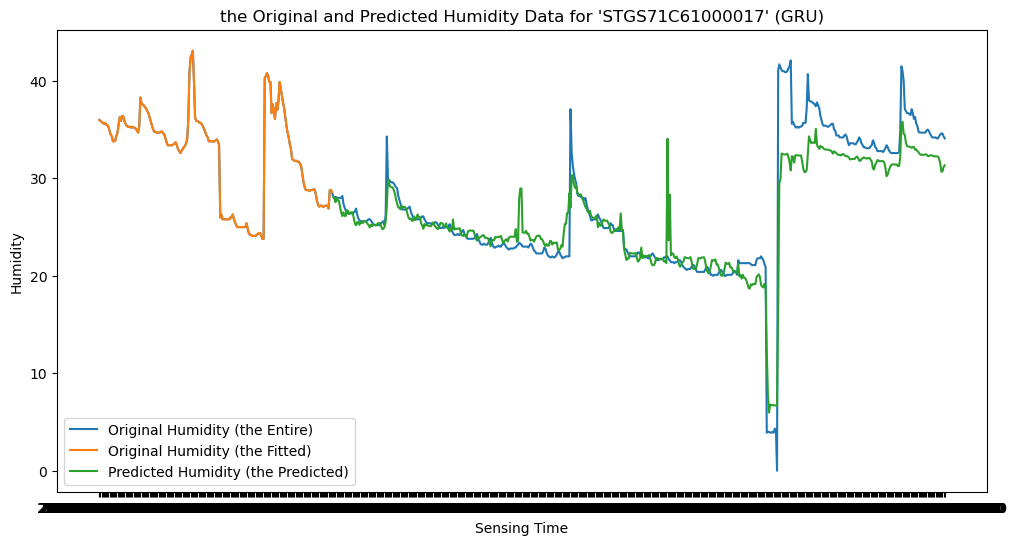

In [68]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000017'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.3556
Epoch 2/50
7/7 [==============================] - 0s 922us/step - loss: 0.2495
Epoch 3/50
7/7 [==============================] - 0s 919us/step - loss: 0.1632
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0986
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0538
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0322
Epoch 7/50
7/7 [==============================] - 0s 917us/step - loss: 0.0219
Epoch 8/50
7/7 [==============================] - 0s 919us/step - loss: 0.0151
Epoch 9/50
7/7 [==============================] - 0s 834us/step - loss: 0.0102
Epoch 10/50
7/7 [==============================] - 0s 919us/step - loss: 0.0083
Epoch 11/50
7/7 [==============================]

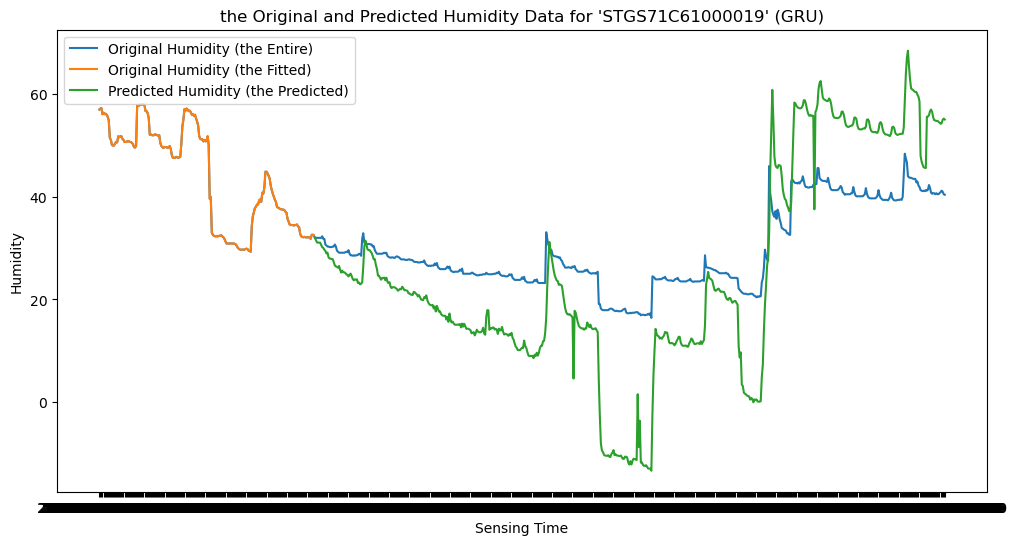

In [69]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000019'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
6/6 [==============================] - 1s 1ms/step - loss: 0.0486
Epoch 2/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 3/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 4/50
6/6 [==============================] - 0s 912us/step - loss: 0.0199
Epoch 5/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 6/50
6/6 [==============================] - 0s 932us/step - loss: 0.0132
Epoch 7/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0114
Epoch 8/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 9/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 10/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 11/50
6/6 [==============================] - 0s 1m

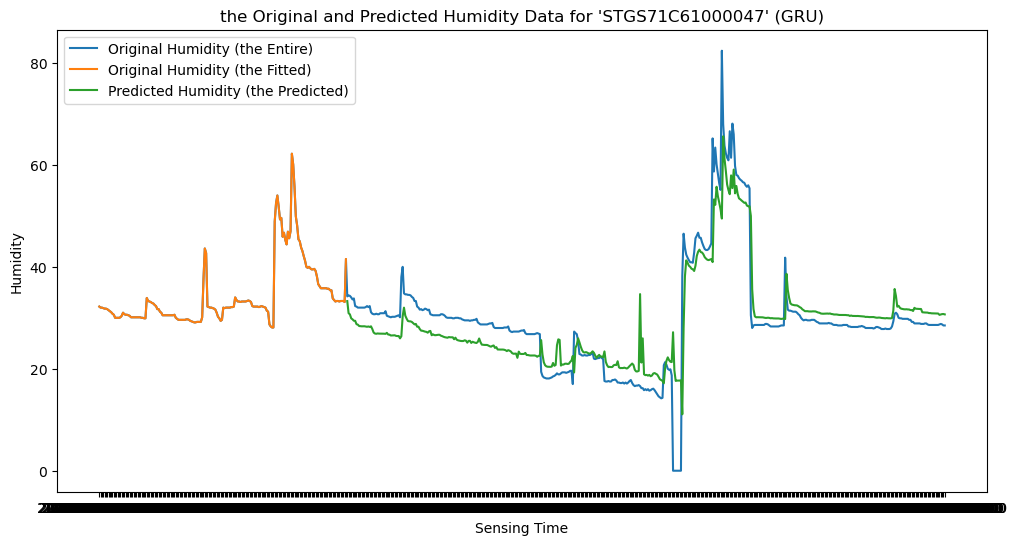

In [70]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000047'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.0410
Epoch 2/50
7/7 [==============================] - 0s 917us/step - loss: 0.0177
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 4/50
7/7 [==============================] - 0s 918us/step - loss: 0.0141
Epoch 5/50
7/7 [==============================] - 0s 919us/step - loss: 0.0105
Epoch 6/50
7/7 [==============================] - 0s 917us/step - loss: 0.0093
Epoch 7/50
7/7 [==============================] - 0s 834us/step - loss: 0.0079
Epoch 8/50
7/7 [==============================] - 0s 835us/step - loss: 0.0070
Epoch 9/50
7/7 [==============================] - 0s 862us/step - loss: 0.0065
Epoch 10/50
7/7 [==============================] - 0s 982us/step - loss: 0.0061
Epoch 11/50
7/7 [===========================

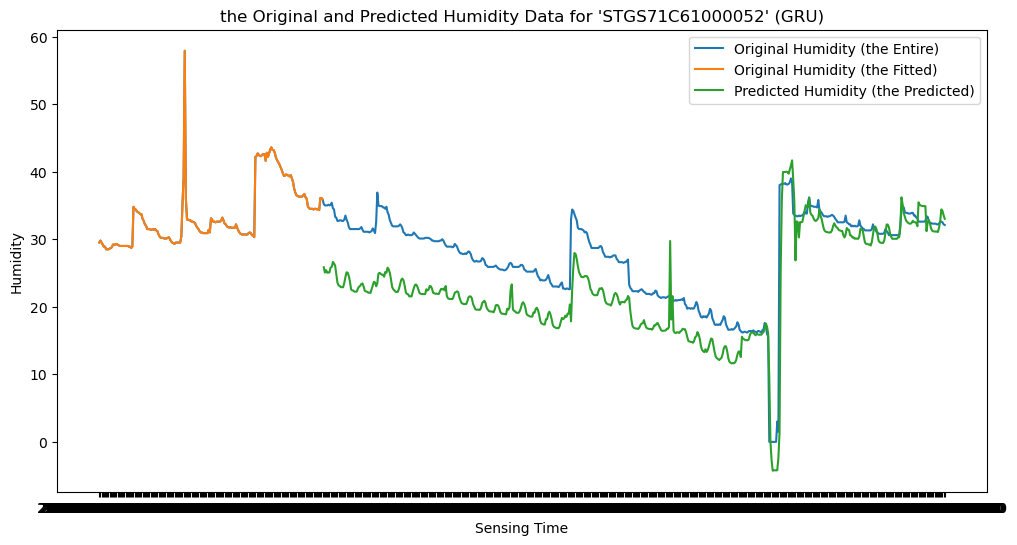

In [71]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000052'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

the Preprocessing initialized.
the Preprocessing done.
Period > 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Period : 1
2023-09
Period > 1
2023-10
Period > 1
2023-11
Epoch 1/50
6/6 [==============================] - 1s 1ms/step - loss: 0.0802
Epoch 2/50
6/6 [==============================] - 0s 800us/step - loss: 0.0496
Epoch 3/50
6/6 [==============================] - 0s 802us/step - loss: 0.0319
Epoch 4/50
6/6 [==============================] - 0s 901us/step - loss: 0.0258
Epoch 5/50
6/6 [==============================] - 0s 800us/step - loss: 0.0232
Epoch 6/50
6/6 [==============================] - 0s 903us/step - loss: 0.0199
Epoch 7/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0157
Epoch 8/50
6/6 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 9/50
6/6 [==============================] - 0s 902us/step - loss: 0.0125
Epoch 10/50
6/6 [==============================] - 0s 800us/step - loss: 0.0112
Epoch 11/50
6/6 [=============================

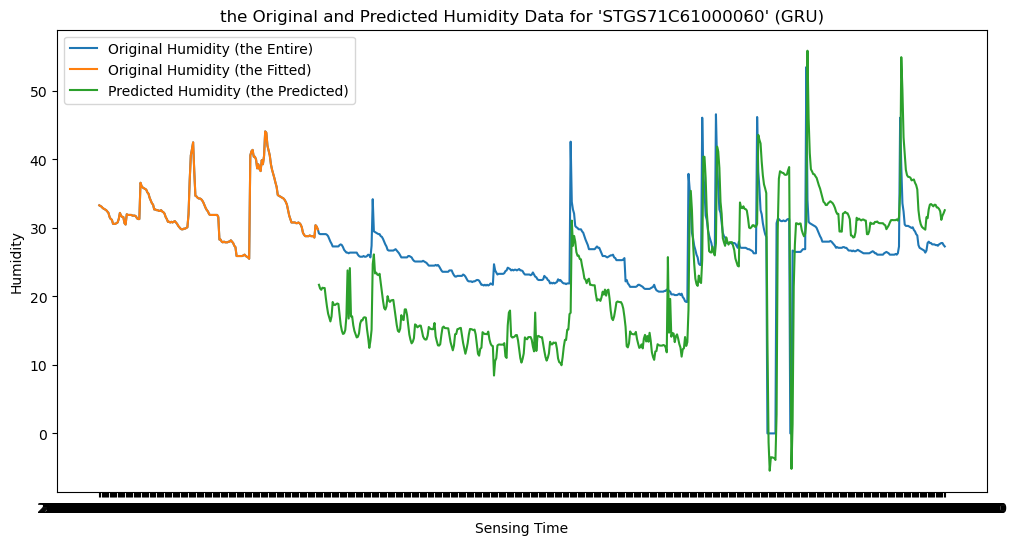

In [72]:
### INPUT PART ### ### ###
### ### ### ### ### ### ###
### INPUT SENSOR NUMBER ###
sensor_num_input = 'STGS71C61000060'
### -----------------------------------------------------------------
# automate process for making sh2 LATER...
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)
### -----------------------------------------------------------------------
### BUILD INPUT ###
year_build = 2023
month_build = 9
period_build = 3
# -------------------------------------------------
### FIT INPUT ###
year_fit = 2023
month_fit = 9
period_fit = 1
# ---------------------
### TARGET INPUT ###
year_target = 2023
month_target = 10
period_target = 2
### ==========================================================================================================================
### ==========================================================================================================================
### PREPROCESS ###
print('the Preprocessing initialized.')
sh2_s_main = sh2[sh2['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual']]
lag_num = 3
# -------------------------------------------------------------------------
# Create lagged features
lagged_df = create_lagged_features(sh2_s_main, lag=lag_num)
# Drop NaN values resulting from lagged features
#lagged_df = lagged_df.dropna()
for i in range(lag_num):
    lagged_df['humi_lag_{}'.format(i+1)].fillna(method='bfill',inplace=True)
# ------------------------------------------------------------------------------------------------------------------------------
lagged_df['sensingTime_'] = pd.to_numeric(lagged_df['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain']
for i in range(len(col_lst)):
    col_k_dash_remover(lagged_df,col_lst[i])
# ---------------------------------------------------------------------------------------------------------------------
x_cols = ['battery', 'temp', 'ph_','ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime_', 'humi_lag_1', 'humi_lag_2', 'humi_lag_3', 'sensingTime']
x_cols_ = [x for x in x_cols if x != 'sensingTime']
y_cols = ['humi']
# ---------------------------------------------------------------------------------------------------------------------
if len(lagged_df[lagged_df['ph'] == '-']) != 0:
    ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()
    lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean
# ------------------------------------------------------------------------
lagged_df['ph_'] = lagged_df['ph'].astype(float) 
lagged_df['k_temp_'] = lagged_df['k_temp'].astype(float) 
lagged_df['k_rain_'] = lagged_df['k_rain'].astype(float) 
# ---------------------------
#time_end1 = time.time()
print('the Preprocessing done.')
#print('Elapsed time 1 : {}'.format(time_end1 - time_start))
### PREPROCESS DONE ###
# ------------------------------------------------------------------------------------------
df_build = ts_df_maker(lagged_df,year_build,month_build,period_build)
df_fit = ts_df_maker(lagged_df,year_fit,month_fit,period_fit)
df_target = ts_df_maker(lagged_df,year_target,month_target,period_target)
# ----------------------------------------------------------------------------
X_build = df_build[x_cols_]
X_fit = df_fit[x_cols_]
y_fit = df_fit[y_cols]
X_target = df_target[x_cols_]
### ====================================================================================
X_build_ = scale_data(X_build)
X_fit_ = scale_data(X_fit)
y_fit_ = scale_data(y_fit)
X_target_,scaler = scale_data_target(X_target)
# ---
y_pred_result = process_model(X_build_,X_fit_,y_fit_,X_target_,scaler)
### ### ### ### ### --------------------------------------------------------------------
### VISUALIZATION ###
df_target_ht = df_target[['sensingTime','humi']].reset_index()
if 0 in y_pred_result.columns:
    y_pred_result_humi = y_pred_result.rename(columns = {0:'humi'})
y_pred_result_humi['humi_diff'] = y_pred_result_humi['humi'] - df_target_ht['humi']
try:
    y_pred_result_humi['humi_'] = (y_pred_result_humi['humi'] - y_pred_result_humi['humi_diff'].mean().round(2)).round(2)
except:
    y_pred_result_humi['humi_'] = round(y_pred_result_humi['humi'] - round(y_pred_result_humi['humi_diff'].mean(),2),2)

df_target_ht.rename(columns = {'humi':'hm_ht'},inplace=True)  
y_pred_result_humi_ = pd.concat([y_pred_result_humi, df_target_ht], axis=1)
### ----------------------------------------------------------------------------------------------------------------------
### data adjustment ###
if len(y_pred_result_humi_) != 0:
    eps = abs(y_pred_result_humi_['humi_'].iloc[0] - y_pred_result_humi_['hm_ht'].iloc[0])
    eps = eps.round(2)
    if eps > 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] - eps
    elif eps < 0:
        y_pred_result_humi_['humi_'] = y_pred_result_humi_['humi_'] + eps
### PLOT ###
plt.figure(figsize=(12, 6))
# Plot original humi data (the Entire)
sns.lineplot(data=sh2_s_main, x='sensingTime', y='humi', label='Original Humidity (the Entire)')
# Plot original humi data (the Fitted)
sns.lineplot(data=df_fit[['sensingTime','humi']], x='sensingTime', y='humi', label='Original Humidity (the Fitted)')
# Plot predicted humi data (the Predicted)
sns.lineplot(data=y_pred_result_humi_, x='sensingTime', y='humi_', label='Predicted Humidity (the Predicted)')
# ---------------------------------------------------------------------------------------------------------------
# Set plot title and labels
plt.title("the Original and Predicted Humidity Data for '{}' (GRU)".format(sensor_num_input))
plt.xlabel('Sensing Time')
plt.ylabel('Humidity')
# Show the legend
plt.legend()
# Show the plot
plt.show()

In [23]:
lagged_df[lagged_df['ph'] == '-']

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,humi_lag_1,humi_lag_2,humi_lag_3,sensingTime_
19494,19495,STGS71C61000010,100,8.6,14.7,-,0.1,598,10,14,9,0,2023-10-29 07:00,0,0,14.8,14.8,15.0,202310290700


In [ ]:
lagged_df[lagged_df['ph'] == '-']

In [ ]:
lagged_df['ph'].replace('-',)

In [35]:
lagged_df[lagged_df['num'] != 19495]['ph'].mean()

TypeError: Could not convert 6.196.26.226.226.236.246.336.436.76.866.956.96.296.236.196.176.136.15.615.826.146.186.196.296.125.995.965.945.925.915.95.916.136.376.576.446.136.136.166.186.216.256.516.896.817.047.016.856.166.136.126.096.096.16.256.166.266.656.646.465.745.685.755.755.745.735.96.26.146.166.136.075.695.665.665.85.675.685.655.595.395.425.985.725.415.385.375.355.345.345.465.855.955.875.645.445.15.075.075.065.055.065.216.036.096.195.995.515.255.225.275.295.315.345.486.286.346.286.055.715.345.325.315.35.365.425.526.436.356.195.965.735.435.385.385.355.525.455.696.176.316.075.975.845.625.585.575.565.585.595.675.785.875.915.955.926.055.865.815.765.735.695.735.835.946.056.066.055.855.85.775.755.725.715.835.986.286.356.36.25.755.715.75.695.675.665.735.996.276.56.396.035.655.635.625.615.65.65.615.745.625.935.965.935.665.625.65.595.575.555.586.236.216.235.865.665.225.195.175.155.135.125.155.845.886.025.695.395.014.994.984.984.974.975.055.125.175.515.345.074.854.844.854.834.834.824.875.335.365.24.95.215.335.165.155.155.35.145.175.865.996.055.645.234.914.885.034.854.834.834.915.315.65.686.946.135.495.465.395.375.395.625.576.026.286.276.226.15.565.525.525.515.495.485.515.695.745.745.725.575.315.525.275.265.265.245.35.465.875.895.735.585.455.415.425.415.415.645.445.896.226.286.195.765.695.675.665.655.645.635.55.665.9265.785.545.895.645.615.655.695.725.665.816.136.326.185.87.076.396.045.695.75.725.715.75.725.685.635.625.785.85.585.385.655.285.145.095.075.145.475.865.795.655.535.295.255.245.225.25.195.175.595.665.154.995.124.764.724.644.664.674.74.865.385.655.575.325.24.874.824.794.794.784.754.815.15.25.094.884.774.784.764.764.754.744.746.996.416.386.386.326.225.975.915.865.845.815.785.746.036.335.965.675.445.025.015.025.045.055.065.135.816.065.85.525.335.035.0154.994.984.974.995.525.295.164.954.794.64.594.594.594.584.574.675.96.746.546.346.256.356.356.066.116.126.126.156.316.376.256.286.276.266.266.156.186.176.166.176.286.486.226.176.136.136.126.136.126.126.126.156.26.26.216.116.096.056.0566.036.036.036.066.226.256.36.196.345.965.955.955.955.925.935.956.176.46.216.126.096.016.016.015.985.9866.236.46.246.416.355.995.985.995.975.975.976.016.196.346.146.1366.066.076.086.16.116.16.136.186.346.256.095.966.086.076.076.066.056.046.226.056.086.136.126.116.126.136.316.136.146.146.176.326.556.266.136.046.226.216.236.236.26.186.26.576.466.356.236.15.615.555.525.495.455.425.435.595.85.765.595.375.055.055.0555.015.395.856.246.316.256.085.997.297.046.96.776.676.66.526.326.486.296.045.515.565.545.525.495.475.435.15.15.595.367.016.235.655.625.615.65.585.565.535.615.985.915.625.475.265.255.255.245.235.185.35.495.665.75.525.485.095.044.975.01504.915.045.365.255.074.944.724.744.754.734.724.724.734.885.115.064.944.834.664.674.674.674.674.664.664.735.054.894.764.74.644.654.654.654.654.654.644.674.974.824.734.674.624.634.634.634.634.634.634.664.984.794.74.664.614.624.634.634.634.634.634.694.94.764.644.644.634.644.644.654.654.654.654.644.624.614.64.64.594.594.594.594.594.594.584.64.584.624.614.594.564.574.694.624.64.584.594.584.714.694.674.644.614.644.654.654.654.654.634.674.814.794.724.68 to numeric

In [39]:
pd.to_numeric(lagged_df[lagged_df['num'] != 19495]['ph']).mean()

5.586889168765744

In [42]:
pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()

5.586889168765744

In [45]:
ph_mean = pd.to_numeric(lagged_df[lagged_df['ph'] != '-']['ph']).mean()

In [53]:
lagged_df.loc[lagged_df['ph'] == '-','ph'] = ph_mean

In [55]:
lagged_df[lagged_df['ph'] == '-']

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,humi_lag_1,humi_lag_2,humi_lag_3,sensingTime_


In [29]:
lagged_df.dtypes

num               int64
sensorName       object
battery           int64
temp            float64
humi            float64
ph               object
ec              float64
nitro             int64
phos              int64
pota              int64
k_temp           object
k_rain           object
sensingTime      object
auto              int64
manual            int64
humi_lag_1      float64
humi_lag_2      float64
humi_lag_3      float64
sensingTime_      int64
dtype: object